In [1]:
import os
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

from IPython.display import Image

from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
force_cpu = False
if not force_cpu:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Using device", device)

Using device cuda


In [4]:
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     root = '/content/drive/MyDrive/Colab Notebooks'
# except:
root = '.'

fig_folder = f"{root}/figures"
backup_folder = f"{root}/backup"

os.listdir(root)
for f in fig_folder, backup_folder:
    os.makedirs(f, exist_ok=True)

print("Backup folder:", backup_folder)
print("Figures folder:", fig_folder)

Backup folder: ./backup
Figures folder: ./figures


In [5]:
batch_size = 64 #  Tutorial: 64
epochs = 15       #  Tutorial : 15

optim_class = torch.optim.RMSprop  #  Tutorial: RMSprop
optim_kwargs = dict(lr=0.001)

In [6]:
FORCE = False # Re-do the computation even if backup files exist

In [7]:
train_loader = DataLoader(
    datasets.MNIST(
        'data', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    datasets.MNIST(
        'data', train=False, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=False)

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = nn.Conv2d(1, 32, 3, padding="same")
        self.enc2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.enc3 = nn.Conv2d(64, 64, 3, padding="same")
        self.enc4 = nn.Conv2d(64, 64, 3, padding="same")
        self.enc5 = nn.Linear(12544, 32)

        self.dec1 = nn.Linear(2, 12544)
        self.dec2 = nn.ConvTranspose2d(64, 32, 3, stride=(2, 2), padding=1, output_padding=1)
        self.dec3 = nn.Conv2d(32, 1, 3, padding="same")

        self.mu = nn.Linear(32, 2)
        self.logvar = nn.Linear(32, 2)

    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc4(x))
        x = x.flatten(start_dim=1)
        x = F.relu(self.enc5(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):

        z = F.relu(self.dec1(z))
        z = z.view(-1, 64, 14, 14)
        z = F.relu(self.dec2(z))
        x = torch.sigmoid(self.dec3(z))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [9]:
# Reconstruction + KL divergence losses summed over all elements and batch
def vae_loss(recon_x, x, mu, logvar):
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    
    return bce + kl

In [10]:
bkp_vae = f"{backup_folder}/vae_alone.p"

if not os.path.exists(bkp_vae) or FORCE:

    vae = VAE().to(device)
    vae.train()

    optimizer = optim_class(vae.parameters(), **optim_kwargs)

    for epoch in tqdm(range(1, epochs + 1)):

        train_loss = 0
        with tqdm(total=len(train_loader),
                  position=1, desc=f"Epoch {epoch}") as pbar:

            for batch_idx, (x, _) in enumerate(train_loader):
                x = x.to(device)
                optimizer.zero_grad()
                recon_x, mu, logvar = vae(x)
                loss = vae_loss(recon_x=recon_x, x=x, mu=mu, logvar=logvar)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.update()
                pbar.set_postfix({"loss": f"{loss.item()/len(x):.4f}"})

        print('====> Epoch: {}\tAverage loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))

    torch.save(vae.state_dict(), bkp_vae)
    
else:
    vae = VAE()
    vae.load_state_dict(torch.load(bkp_vae, map_location=device))
    
vae_alone = vae

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.pred1 = nn.Linear(2, 128)
        self.pred2 = nn.Linear(128, 128)
        self.pred3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = F.log_softmax(self.pred3(x), dim=1)
        return x

In [12]:
def classifier_loss(y, pred):
    loss = nn.CrossEntropyLoss(reduction="sum")
    # loss = nn.NLLLoss(reduction='sum')
    return loss(pred, y)

In [13]:
bkp_vae = f"{backup_folder}/vae_and_classifier__vae.p"
bkp_clas = f"{backup_folder}/vae_and_classifier__classifier.p"

if not os.path.exists(bkp_vae) or not os.path.exists(bkp_clas) or FORCE:

    vae = VAE().to(device)
    classifier = Classifier().to(device)
    vae.train()
    classifier.train()

    optimizer = optim_class(list(vae.parameters()) + list(classifier.parameters()), **optim_kwargs)
    
    weight_clas_loss = 20
    
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
        
        with tqdm(total=len(train_loader),
                  position=1, desc=f"Epoch {epoch}") as pbar:
            
            for batch_idx, (x, y) in enumerate(train_loader):

                x, y = x.to(device), y.to(device)
                
                optimizer.zero_grad()
                
                recon_x, mu, logvar = vae(x)
                l_vae = vae_loss(recon_x=recon_x, x=x, mu=mu, logvar=logvar)
                
                pred = classifier(mu)
                l_class = weight_clas_loss*classifier_loss(y=y, pred=pred)

                loss = l_vae + l_class
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.update()
                pbar.set_postfix({
                    "loss VAE": f"{l_vae.item()/len(x):.4f}",
                    "loss classifier": f"{l_class.item()/len(x):.4f}"})

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))

    torch.save(vae.state_dict(), bkp_vae)
    torch.save(classifier.state_dict(), bkp_clas)
    
else:
    vae = VAE().to(device)
    vae.load_state_dict(torch.load(bkp_vae))
    classifier = Classifier().to(device)
    classifier.load_state_dict(torch.load(bkp_clas))

vae_and_classifier__vae = vae
vae_and_classifier__clas = classifier

In [14]:
def test_vae(model, model_name=""):
    model.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            test_loss += vae_loss(recon_x, x, mu, logvar).item()
            if i == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n],
                                      recon_x.view(batch_size, 1, 28, 28)[:n]])
                img_file = f'{fig_folder}/reconstruction_{model_name}.png'
                save_image(comparison.cpu(), img_file, nrow=n)
                display(Image(filename=img_file))

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

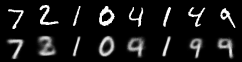

====> Test set loss: 145.9352


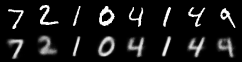

====> Test set loss: 145.2962


In [15]:
test_vae(vae_alone, model_name="vae_alone")
test_vae(vae_and_classifier__vae, model_name="vae_and_classifier")

In [16]:
def nll_digit(i, h_flat, y_flat):

    mvn = multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]])
    nll_prior = -mvn.logpdf(h_flat.cpu().numpy()).reshape(-1, 1)
    return nll_prior - np.log(y_flat[:,i] + 1e-8).reshape(-1, 1)

def nll_plot(gx, gy, h_flat, y_flat):
    
    fig = plt.figure(figsize=(15, 6))
    plt.subplots_adjust(hspace=0.4)

    for i in range(10):
        plt.subplot(2, 5, i+1)
        gz = nll_digit(i=i, h_flat=h_flat, y_flat=y_flat).reshape(gx.shape)
        im = plt.contourf(gx, gy, gz, 
                          cmap='coolwarm', 
                          norm=LogNorm(), 
                          levels=np.logspace(0.2, 1.8, 100))
        plt.title(f'Target = {i}')
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)

    fig.subplots_adjust(right=0.8)
    fig.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]), 
                 ticks=np.logspace(0.2, 1.8, 11), format='%.2f', 
                 label='Negative log likelihood')

def plot_nll_using_classifier_latent2dig(classifier_latent2dig):
    
    rx, ry = np.arange(-4, 4, 0.10), np.arange(-4, 4, 0.10)
    gx, gy = np.meshgrid(rx, ry)

    h_flat = np.c_[gx.ravel(), gy.ravel()]
    h_flat = torch.from_numpy(h_flat).float().to(device)
    with torch.no_grad():
        logp = classifier_latent2dig(h_flat)
    y_flat = logp.exp().cpu().numpy()

    nll_plot(gx=gx, gy=gy, h_flat=h_flat, y_flat=y_flat)

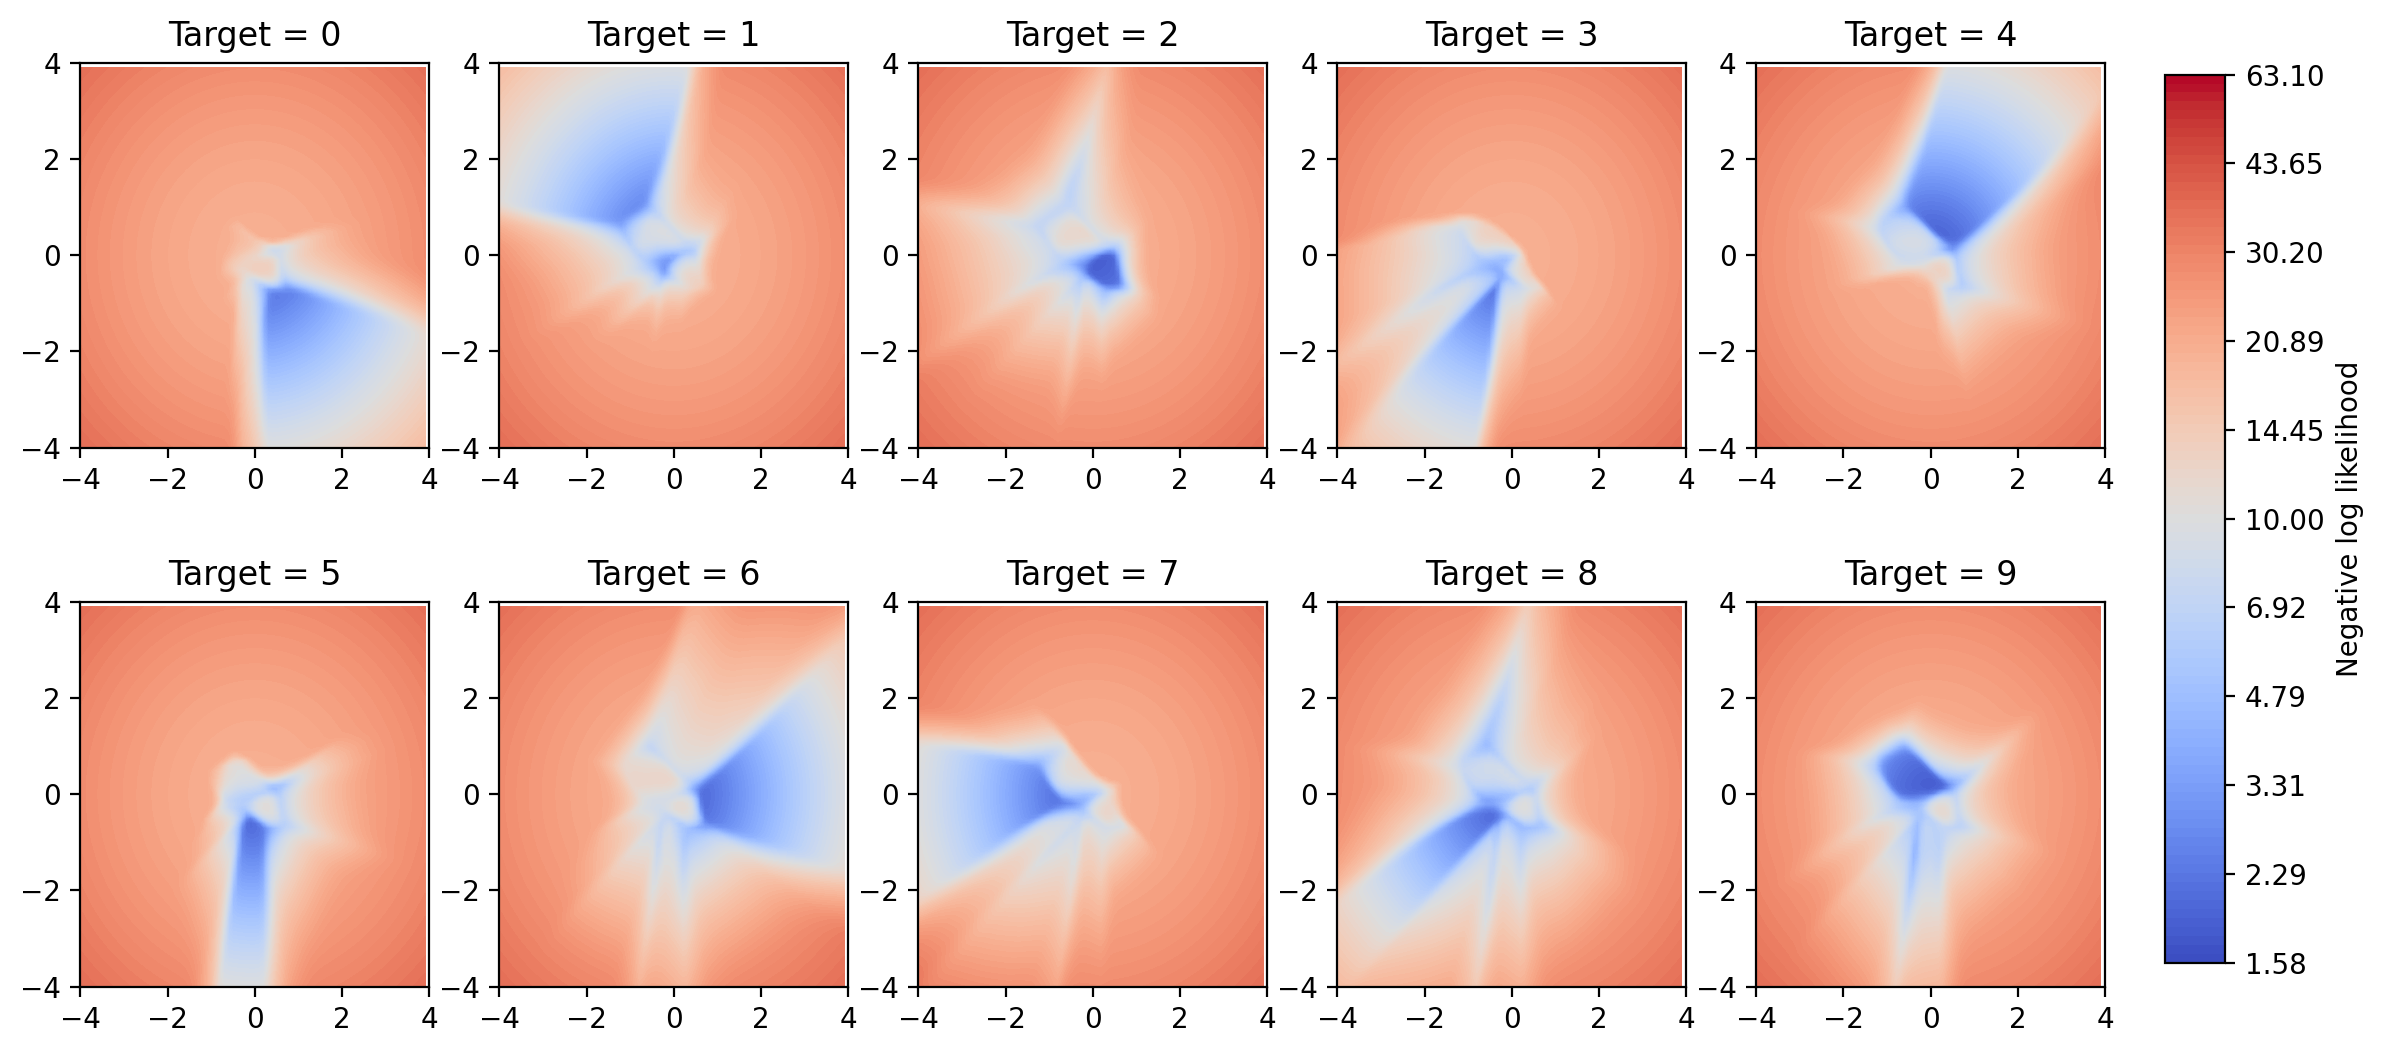

In [17]:
plot_nll_using_classifier_latent2dig(vae_and_classifier__clas)

In [18]:
def plot_latent_space(models):
    
    test_loader = DataLoader(
    datasets.MNIST(
        'data', train=False, transform=transforms.ToTensor()),
        batch_size=5000, shuffle=False)

    x_test = None
    y_test = None
    for _, (x, y) in enumerate(test_loader):
        x_test = x
        y_test = y
        break

    ts = []
    for model in models.values():
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            recon_batch, mu, logvar = model(x_test.to(device))
            ts.append(mu.cpu().numpy())

    if not isinstance(y_test, np.ndarray):
        y_test = y_test.numpy()

    titles = list(models.keys())

    fig, axes = plt.subplots(ncols=len(ts), figsize=(5*len(ts), 4))
    cmap = plt.get_cmap('viridis', 10)

    for i, t in enumerate(ts):
        try:
            ax = axes[i]
        except TypeError:
            ax = axes

        im = ax.scatter(
            t[:, 0], t[:, 1], c=y_test,
            cmap=cmap,
            vmin=-0.5, vmax=9.5,
            marker='o', s=0.4)
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        ax.set_title(titles[i])

    fig.subplots_adjust(right=0.8)
    plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]), ticks=range(10))
    plt.show()

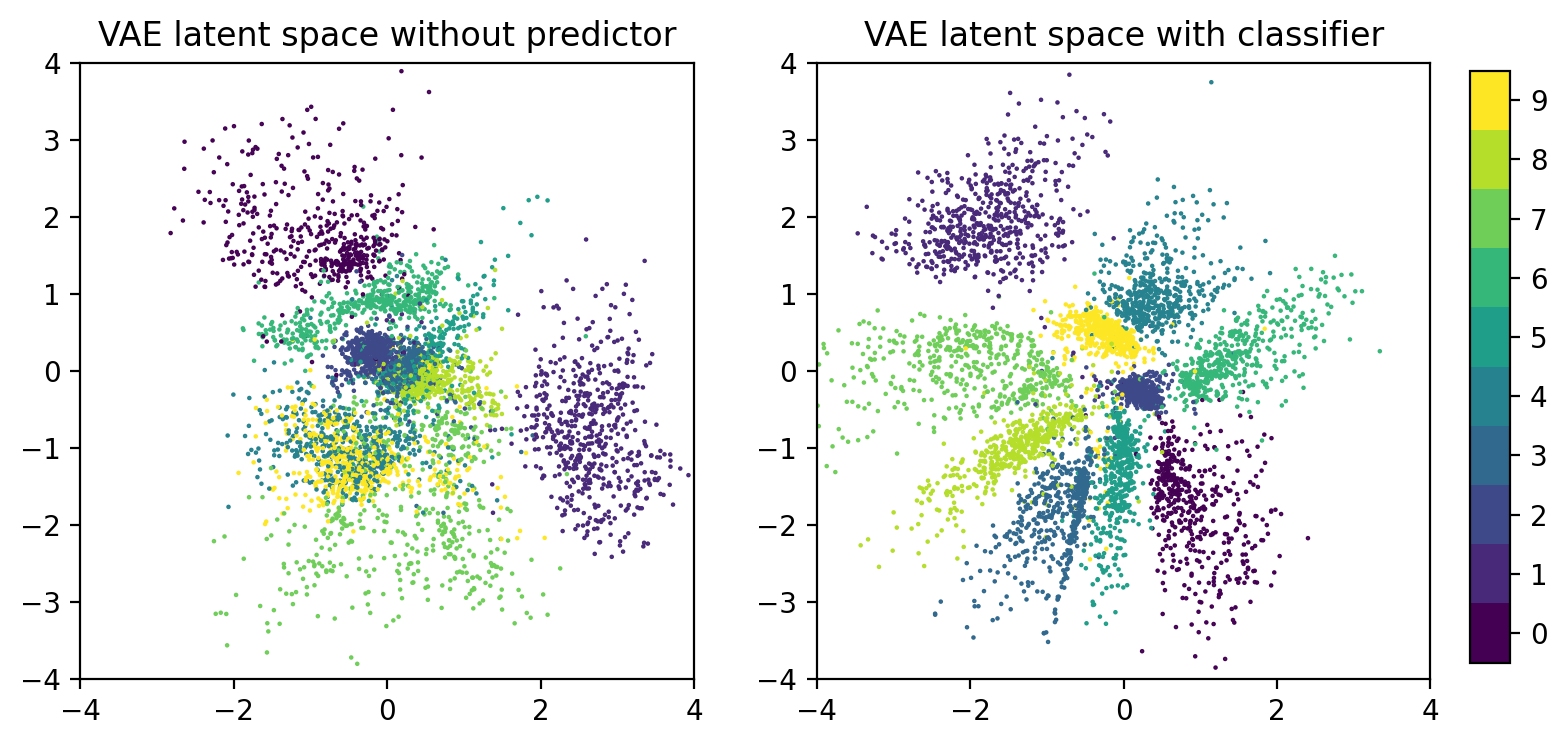

In [19]:
plot_latent_space({
    'VAE latent space without predictor': vae_alone, 
    'VAE latent space with classifier': vae_and_classifier__vae})

In [20]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.pred1 = nn.Linear(2, 128)
        self.pred2 = nn.Linear(128, 128)
        self.pred3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = self.pred3(x)
        return x

In [21]:
def regressor_loss(y, pred):
    loss = nn.MSELoss(reduction="sum")
    output = loss(pred.squeeze(), y.float())
    return output

In [22]:
bkp_vae = f"{backup_folder}/vae_and_regressor__vae.p"
bkp_reg = f"{backup_folder}/vae_and_regressor__regressor.p"

force = False

if not os.path.exists(bkp_vae) or not os.path.exists(bkp_reg) or force:
    
    vae = VAE().to(device)
    reg = Regressor().to(device)
    
    vae.train()
    reg.train()

    optimizer = optim_class(list(vae.parameters())+list(reg.parameters()), **optim_kwargs)
    
    weight_reg_loss = 20

    for epoch in tqdm(range(1, epochs + 1)):
        
        train_loss = 0
        
        with tqdm(total=len(train_loader),
                  position=1, desc=f"Epoch {epoch}") as pbar:
            
            for batch_idx, (x, y) in enumerate(train_loader):

                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                
                recon_x, mu, logvar = vae(x)
                l_vae = vae_loss(recon_x=recon_x, x=x, mu=mu, logvar=logvar)
                
                pred = reg(mu)
                l_reg = weight_reg_loss*regressor_loss(y=y, pred=pred)

                loss = l_vae + l_reg
                
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.update()
                pbar.set_postfix({
                    "loss VAE": f"{l_vae.item()/len(x):.4f}",
                    "loss regressor": f"{l_reg.item()/len(x):.4f}"})

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))

    torch.save(vae.state_dict(), bkp_vae)
    torch.save(reg.state_dict(), bkp_reg)
    
else:
    vae = VAE().to(device)
    vae.load_state_dict(torch.load(bkp_vae))
    reg = Regressor().to(device)
    reg.load_state_dict(torch.load(bkp_reg))

vae_and_regressor__vae = vae
vae_and_regressor__reg = reg

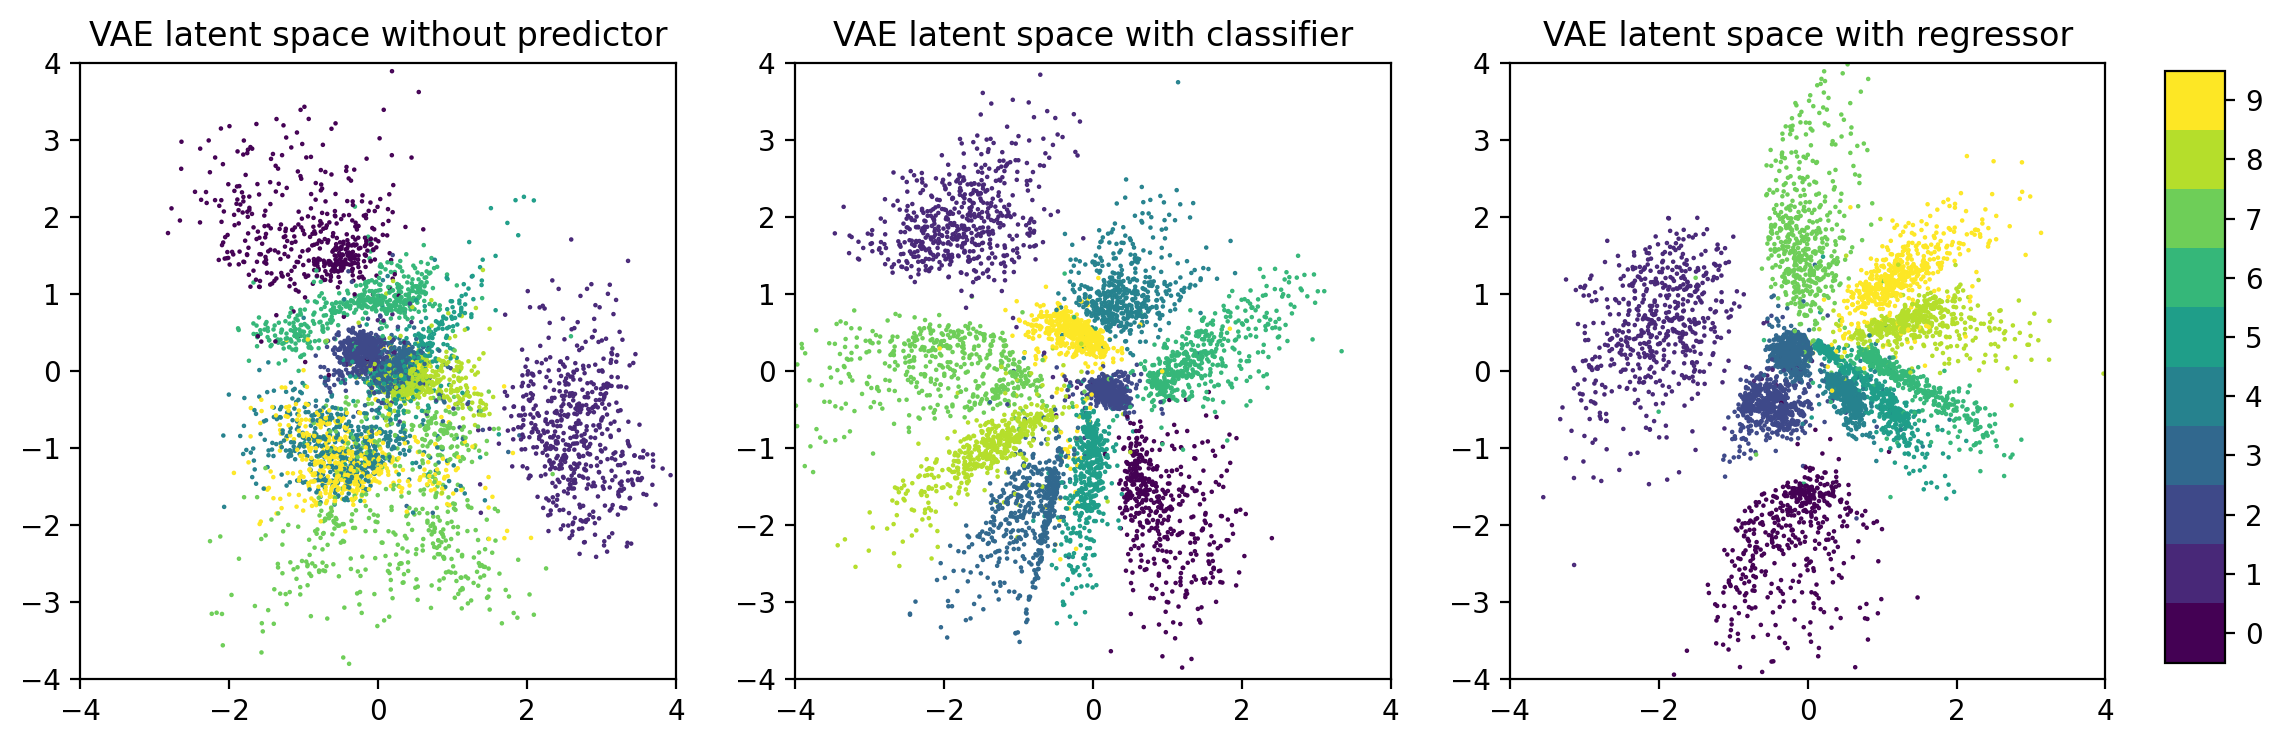

In [23]:
plot_latent_space({
    'VAE latent space without predictor': vae_alone, 
    'VAE latent space with classifier': vae_and_classifier__vae,
    'VAE latent space with regressor': vae_and_regressor__vae})

In [24]:
class ClassifierPicToDigit(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding="valid")
        self.maxpool1 = nn.MaxPool2d(2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, padding="valid")
        self.maxpool2 = nn.MaxPool2d(2, padding=0)
        self.conv3 = nn.Conv2d(64, 64, 3, padding="valid")
        self.dense1 = nn.Linear(576, 64)
        self.dense2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = x.flatten(start_dim=1)
        x = F.relu(self.dense1(x))
        x = F.log_softmax(self.dense2(x), dim=1)
        return x

In [25]:
bkp_cls_pic2dig = f"{backup_folder}/classifier_pic2dig.p"

if not os.path.exists(bkp_cls_pic2dig) or FORCE:
    
    cls = ClassifierPicToDigit().to(device)
    cls.train()

    optimizer = optim_class(cls.parameters(), **optim_kwargs)

    for epoch in tqdm(range(1, epochs + 1)):
        
        train_loss = 0
        
        with tqdm(total=len(train_loader),
                  position=1, desc=f"Epoch {epoch}") as pbar:
            
            for batch_idx, (x, y) in enumerate(train_loader):

                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                
                pred = cls(x)
                loss = classifier_loss(y=y, pred=pred)
                
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.update()
                pbar.set_postfix({"loss": f"{loss.item()/len(x):.4f}"})

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))
        
    torch.save(cls.state_dict(), bkp_cls_pic2dig)
else:
    cls = ClassifierPicToDigit()
    cls.load_state_dict(torch.load(bkp_cls_pic2dig))
    
classifier_pic2dig = cls 

torch.Size([6400, 2])


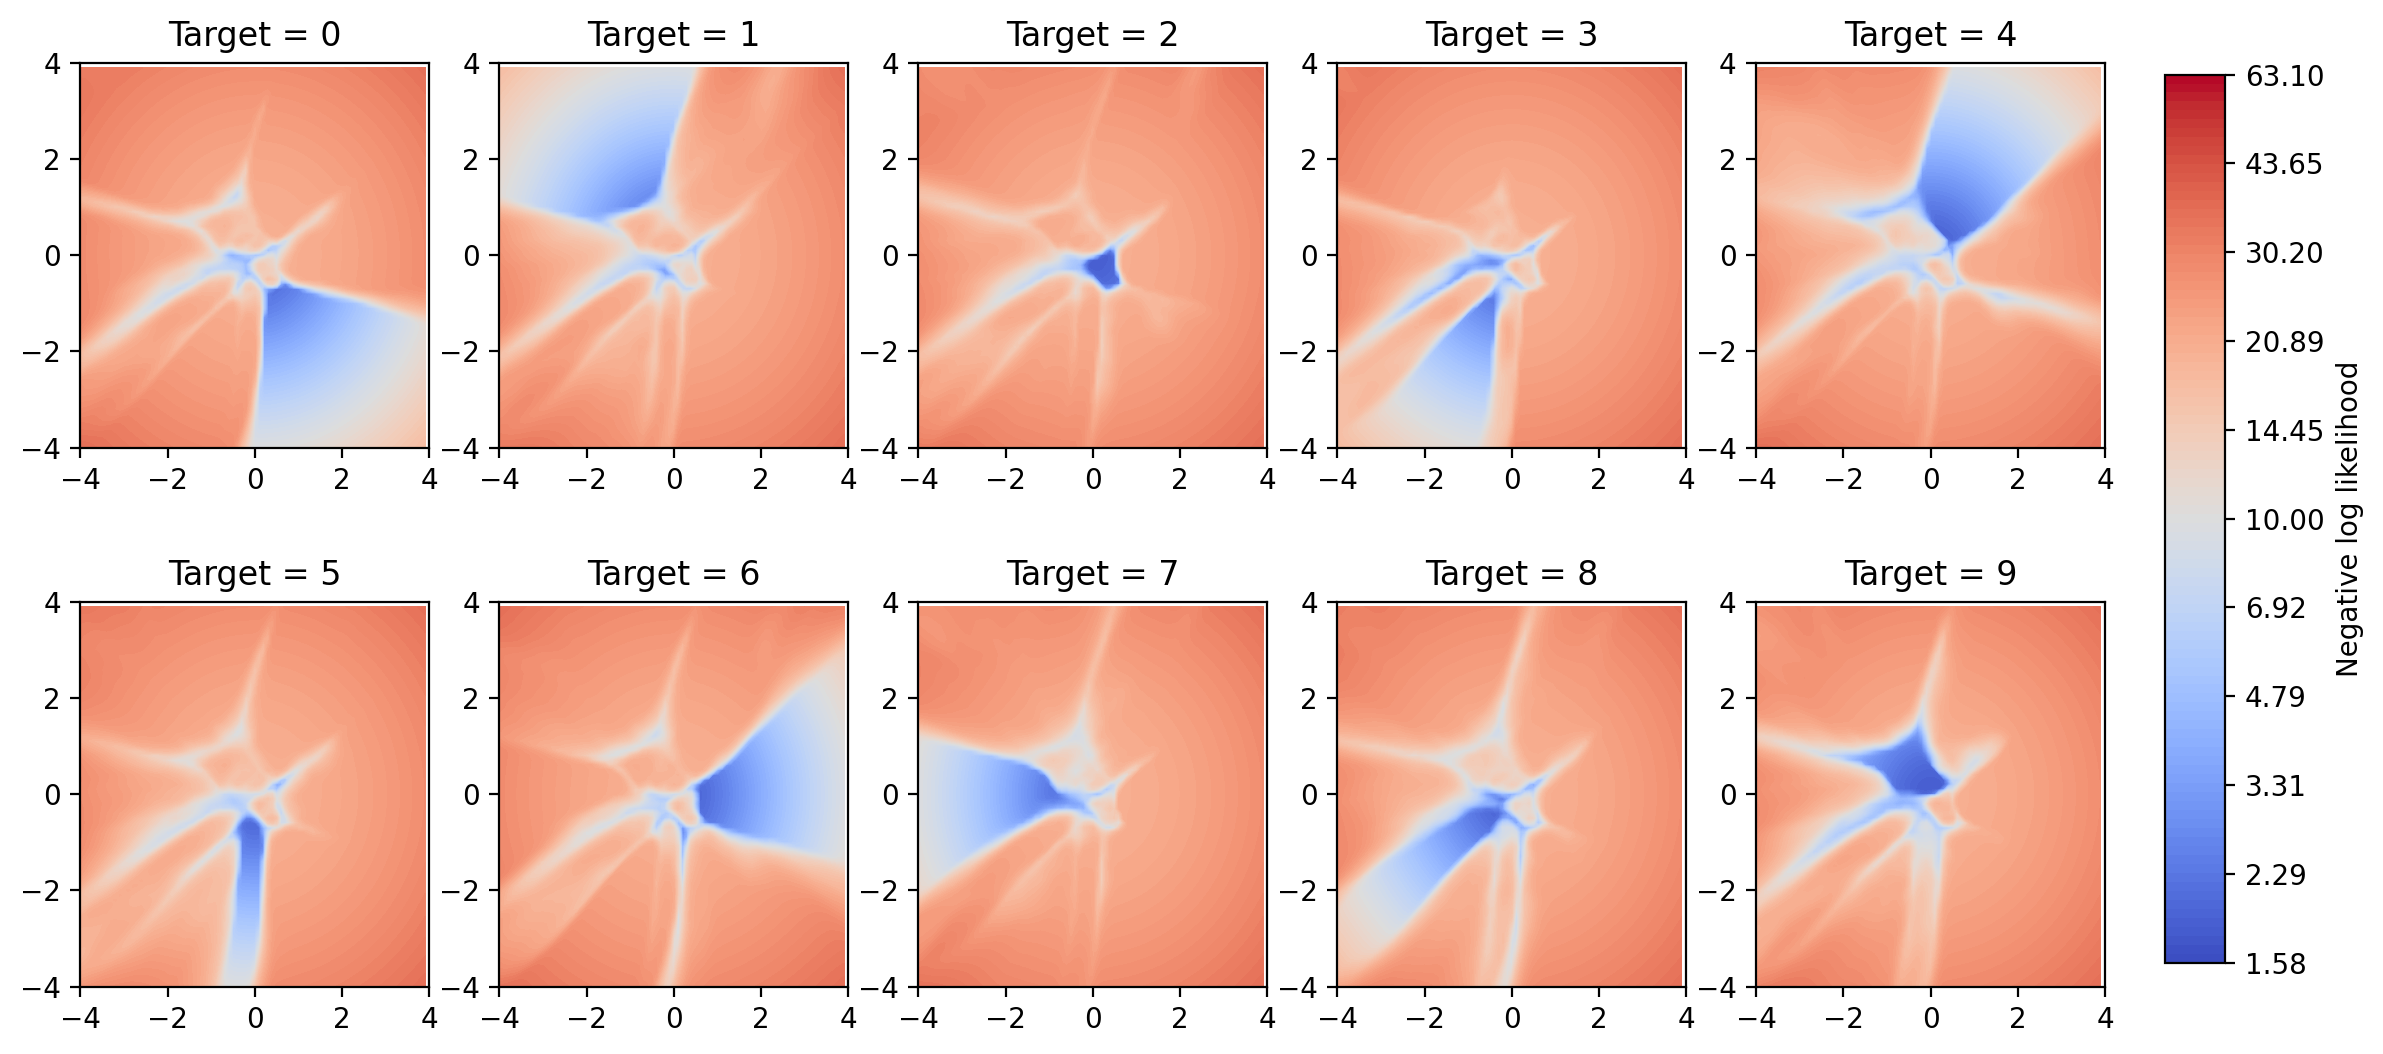

In [26]:
def plot_nll_using_classifier_pic2dig(vae, classifier_pic2dig):
    
    vae = vae.to(device)
    classifier_pic2dig = classifier_pic2dig.to(device)
    
    rx, ry = np.arange(-4, 4, 0.10), np.arange(-4, 4, 0.10)
    gx, gy = np.meshgrid(rx, ry)

    h_flat = np.c_[gx.ravel(), gy.ravel()]
    h_flat = torch.from_numpy(h_flat).float().to(device)
    with torch.no_grad():
        print(h_flat.shape)
        pix = vae.decode(h_flat)
        logp = classifier_pic2dig(pix)
    y_flat = logp.exp().cpu().numpy()

    nll_plot(gx=gx, gy=gy, h_flat=h_flat, y_flat=y_flat)
    
plot_nll_using_classifier_pic2dig(vae=vae_and_classifier__vae, classifier_pic2dig=classifier_pic2dig)

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
SMOKE_TEST = False
dtype = torch.float

VAE_MODEL = vae_and_classifier__vae # vae_alone (works not so good)
CLASSIFIER_PIC2DIGIT = classifier_pic2dig

d = 2
bounds = torch.tensor([[-4.] * d, [4.] * d], device=device, dtype=dtype)

def decode(train_x):
    with torch.no_grad():
        decoded = VAE_MODEL.decode(train_x)     # !!!!!!! #
    return decoded.view(train_x.shape[0], 1, 28, 28)

def score_image_recognition(x):
    """The input x is an image and an expected score based on the CNN classifier and
    the scoring function is returned.
    """
    
    def score(y, target_digit=4):
        """Returns a 'score' for each digit from 0 to 9. It is modeled as a squared exponential
        centered at the digit `target_digit`.
        """
        return torch.exp(-2 * (y - target_digit)**2)
    
    with torch.no_grad():
        probs = torch.exp(CLASSIFIER_PIC2DIGIT(x))  # b x 10      # !!!!!!! #
        scores = score(torch.arange(10, device=device, dtype=dtype)).expand(probs.shape)
    return (probs * scores).sum(dim=1)


def gen_initial_data(n=5):
    # generate training data  
    train_x = unnormalize(torch.rand(n, d, device=device, dtype=dtype), bounds=bounds)
    train_obj = score_image_recognition(decode(train_x)).unsqueeze(-1)  # add output dimension
    best_observed_value = train_obj.max().item()
    return train_x, train_obj, best_observed_value


def get_fitted_model(train_x, train_obj, state_dict=None):
    # initialize and fit model
    model = SingleTaskGP(train_X=train_x, train_Y=train_obj)
    if state_dict is not None:
        model.load_state_dict(state_dict)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    fit_gpytorch_mll(mll)
    return model


BATCH_SIZE = 3 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 256 if not SMOKE_TEST else 4


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation"""
    
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.stack([
            torch.zeros(d, dtype=dtype, device=device), 
            torch.ones(d, dtype=dtype, device=device),
        ]),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )

    # observe new values 
    new_x = unnormalize(candidates.detach(), bounds=bounds)
    new_obj = score_image_recognition(decode(new_x)).unsqueeze(-1)  # add output dimension
    return new_x, new_obj

seed=1
torch.manual_seed(seed)

N_BATCH = 50 if not SMOKE_TEST else 3
MC_SAMPLES = 2048 if not SMOKE_TEST else 32
best_observed = []

# call helper function to initialize model
train_x, train_obj, best_value = gen_initial_data(n=5)
best_observed.append(best_value)

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in tqdm(range(N_BATCH)):    

    # fit the model
    model = get_fitted_model(
        normalize(train_x, bounds=bounds), 
        standardize(train_obj), 
        state_dict=state_dict,
    )
    
    # define the qNEI acquisition module using a QMC sampler
    qmc_sampler = SobolQMCNormalSampler(sample_shape=MC_SAMPLES, seed=seed)
    qEI = qExpectedImprovement(model=model, sampler=qmc_sampler, best_f=standardize(train_obj).max())

    # optimize and get new observation
    new_x, new_obj = optimize_acqf_and_get_observation(qEI)

    # update training points
    train_x = torch.cat((train_x, new_x))
    train_obj = torch.cat((train_obj, new_obj))

    # update progress
    best_value = train_obj.max().item()
    best_observed.append(best_value)
    
    state_dict = model.state_dict()

  0%|          | 0/50 [00:00<?, ?it/s]

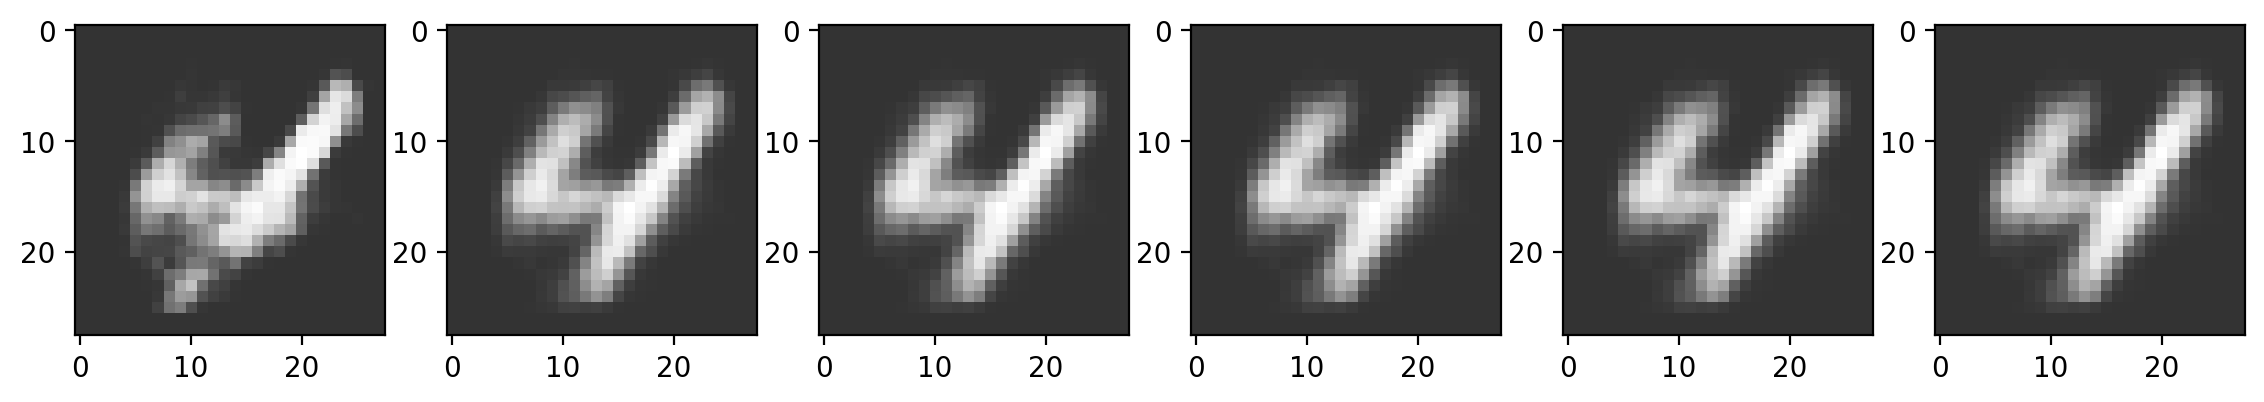

In [29]:
fig, ax = plt.subplots(1, 6, figsize=(14, 14))
percentages = np.array([0, 10, 25, 50, 75, 100], dtype=np.float32)
inds = (N_BATCH * BATCH_SIZE * percentages / 100 + 4).astype(int)

for i, ax in enumerate(ax.flat):
    b = torch.argmax(score_image_recognition(decode(train_x[:inds[i],:])), dim=0)
    img = decode(train_x[b].view(1, -1)).squeeze().cpu()
    ax.imshow(img, alpha=0.8, cmap='gray')